# Compare metrics between all 'Triplets' and 'Permutations'

how different set or subsets of stimuly affect the estimation of temporal integration metrics.

In [ ]:
import itertools as itt
import pathlib as pl
from configparser import ConfigParser
from textwrap import fill

import joblib as jl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sst
import seaborn as sns
from cycler import cycler
from ipywidgets import interact, fixed

import src.visualization.fancy_plots as fplt
from src.data.cache import set_name
from src.metrics.reliability import signal_reliability
from src.data.rasters import raster_from_sig
import src.data.dPCA as cdPCA
from src.data.load import load
from src.metrics.dprime import flip_dprimes

In [2]:
plt.style.use('dark_background')
# modify figure color cycler back to the default one
color_cycler = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

params = {'legend.fontsize': 'medium',
          'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': color_cycler,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [6,6],
          'figure.autolayout':True,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial'
          }

plt.rcParams.update(params)


In [3]:
config = ConfigParser()
config.read_file(open(pl.Path().cwd().parent / 'config' / 'settings.ini'))

In [14]:
meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'transitions': ['silence', 'continuous', 'similar', 'sharp'],
        'montecarlo': 1000,
        'zscore': True,
        'dprime_absolute': None}

# triplets DF
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / 'DF_summary' / set_name(meta)
trpDF = jl.load(summary_DF_file)
# create the id_probe pair for
trpDF['id_probe'] = trpDF['cellid'].fillna(value=trpDF['siteid'])
trpDF['id_probe'] = trpDF[['id_probe', 'probe']].agg('_'.join, axis=1)
trpDF['stim'] = 'triplets'
trpDF.replace(to_replace={'dPCA': 'pdPCA'}, inplace=True)

In [5]:
meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'transitions': [0, 1, 2, 3, 4],
        'montecarlo': 1000,
        'zscore': True,
        'dprime_absolute': None}

# permutations DF
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / 'prm_summary_DF_v2' / set_name(meta)
permDF = jl.load(summary_DF_file)
#create the id_probe pair for
permDF['id_probe'] = permDF['cellid'].fillna(value=permDF['siteid'])
permDF['id_probe'] = permDF[['id_probe', 'probe']].agg('_'.join, axis=1)
permDF['stim'] = 'permutations'


In [55]:
DF = pd.concat([trpDF, permDF])
DF['id'] = DF['cellid']
DF['id'].fillna(DF['siteid'], inplace=True)


In [62]:
# common parameters
analysis = ['SC', 'pdPCA']

ff_parameter = DF.parameter.isin(['significant_abs_sum', 'significant_abs_mass_center'])
ff_analysis = DF.analysis.isin(analysis)
ff_source = DF.source == 'dprime'
ff_probe = DF.probe == 'mean'
ff_transpair= DF.transition_pair == 'mean'
ff_good = DF.value > 0 # empirical good value to filter out garbage cells

filtered = DF.loc[ff_parameter & ff_analysis & ff_source & ff_probe & ff_transpair & ff_good,
                  ['id', 'parameter', 'analysis', 'stim', 'value']]

In [69]:
pivoted = filtered.pivot_table(index=['id', 'parameter', 'analysis'],
                               columns='stim', values='value').dropna().reset_index()

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


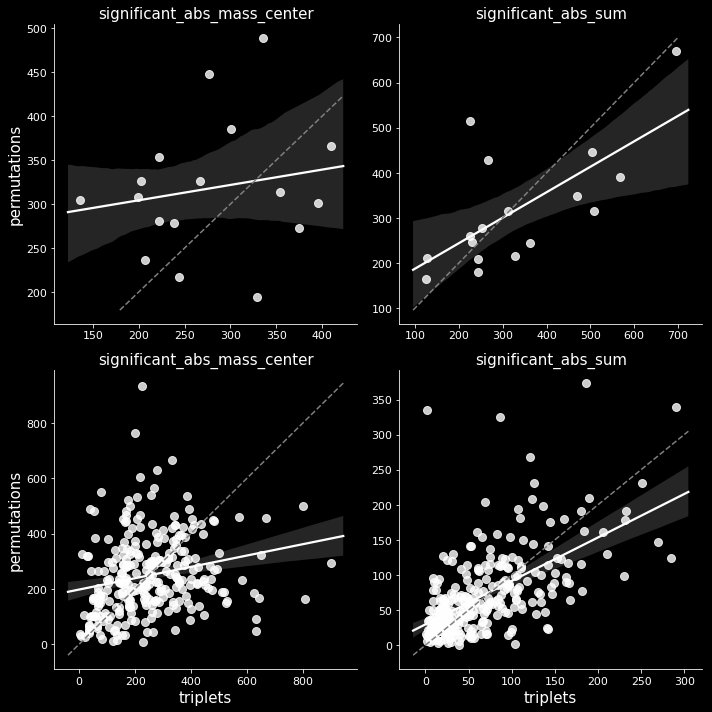

In [70]:
g = sns.lmplot(x='triplets', y='permutations', col='parameter', row='analysis', data=pivoted,
                 sharex=False, sharey=False,
                 scatter_kws={'color':'white'}, line_kws={'color':'white'})
g.set_titles('{col_name}')
g.fig.tight_layout()

for ax in g.axes.flat:
    _ = fplt.unit_line(ax)



This is rather unerving. I would have expected a rather similar calculatede value, given that the triplets and
permutation approaches share 2 sounds. there is no clear reasone why a cell should so widely different contextual effects.
Somewhow the presence of two novel sounds in the permutations paradigm generates a lot of variation in the metric estimation.

Whit this in mind I think it makes sense to increase the number of sounds used in permutations and see if there is any sort
of correlation between the metric values infered with increasingly bigger sets of sounds

Tthere is a somewhat stronger correlation when considering the context effect integral, which reinforces my
believe that it is much more robust and reliable metric. this divetails into the need of a cleaner threshold for
spureous significance, which while not affecting the integral a lot, do shift the center of mass and might be misleading.